In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions


In [7]:

def perturb_normal_mixture(orig_means, orig_variances, orig_weights, 
                           comp_out=10000, alpha=500):
    """
    Returns a perturbation of a mixture:
    
    Given a mixture
            f(y) = \sum_j w_j N(y | \mu_j, \Sigma_j)
    returns
            f'(y) = \sum_k w'_k N(y | \mu'_j, 0.2^2 * I)
    where
    1. mu'_k are the new location centers, obtained by sampling
            c_k ~ Categorical(w_1, .. w_J)
            mu'_k | c_k ~ N(mu_{c_k}, \Sigma_{c_k})
              for k=1, ... comp_out
    2. w'_k are normalized weights (sum to 1) and their length
       is `comp_out` 
           w_k ~ Dirichlet(alpha/comp_out)
    
    """
    univariate = len(orig_means.shape) == 1
    
    c_ks = np.random.choice(
        len(orig_weights), size=comp_out, replace=True, p=orig_weights)
    print(c_ks)
    
    if univariate:
        locations = tfd.Normal(orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.ones(comp_out) * 0.2 ** 2
    else:
        locations = tfd.MultivariateNormalFullCovariance(
            orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.stack([np.eye(orig_means.shape[1] * 0.2 ** 2)] * comp_out)
    weights = tfd.Dirichlet(np.ones(comp_out) * alpha / comp_out).sample()
    return locations, variances, weights

def eval_univariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.Normal(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)


[3 1 3 ... 3 2 2]


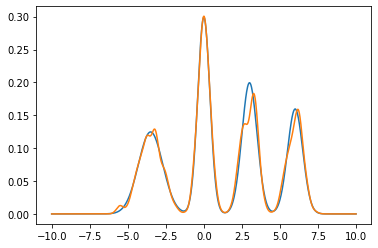

In [10]:

true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5]) ** 2
w_t = np.array([0.25, 0.25, 0.3, 0.2])

pert_mu, pert_sigma, pert_w = perturb_normal_mixture(true_mu, true_sigma, w_t)

xgrid = np.linspace(-10, 10, 1000)
plt.plot(xgrid, eval_univariate_mixture_dens(true_mu, true_sigma, w_t, xgrid))
plt.plot(xgrid, eval_univariate_mixture_dens(pert_mu, pert_sigma, pert_w , xgrid))

In [11]:
pert_mu[2:30]
pert_w[2:30]

array([3.41736411e-09, 6.10866544e-06, 6.40636347e-06, 1.42129324e-35,
       1.14837550e-15, 1.71003921e-05, 7.57496941e-10, 5.04870140e-08,
       1.20934719e-08, 1.73890753e-09, 1.23398247e-19, 2.46507553e-14,
       7.43246755e-07, 4.80054092e-05, 4.72295766e-30, 1.00638758e-07,
       5.93761794e-08, 5.93831677e-04, 9.40677461e-08, 4.63055141e-07,
       2.78782485e-08, 1.28220709e-13, 7.92061506e-15, 1.11059535e-13,
       1.25753631e-28, 1.20421789e-03, 2.21156259e-08, 3.94469741e-11])

In [55]:
sum(pert_w)

0.9999999999999999